In [ ]:
!pip install TensorFlow
!pip install Keras
!pip install pillow
!pip install NumPy
!pip install tqdm
!pip install jupyterlab
!pip install ipywidgets
!pip install pydot
!pip install matplotlib

In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load

In [13]:
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization


In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import  tqdm #to check loop progress

In [4]:
import string

# Load the document file into memory
def load_doc(filename):
    # Open file to read
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

# Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and a
            descp = [wrd for wrd in descp if len(wrd) > 1]
            # Remove words containing numbers
            descp = [wrd for wrd in descp if wrd.isalpha()]
            # Converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

# To build vocab of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

# Set these paths according to project folder in your system
dataset_text = "./Flicker8k_text"
dataset_images = "./Flicker8k_Dataset"

# Prepare text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
# Loading the file that contains all data and mapping them into descriptions dictionary
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))

# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 8092
Length of vocabulary = 8422


In [44]:
# def extract_features(directory):
#     model = Xception(include_top=False, pooling='avg')
#     features = {}
#     for pic in tqdm(os.listdir(directory)):
#         file = os.path.join(directory, pic)
#         image = Image.open(file)
#         image = image.resize((299, 299))
#         image = np.expand_dims(image, axis=0)
#         # image = preprocess_input(image)
#         image = image / 127.5
#         image = image - 1.0
#         feature = model.predict(image)
#         features[pic] = feature
#     return features

# # Set the directory path according to your system
# dataset_images = "./Flicker8k_Dataset"

# # Extract features and save to a pickle file
# features = extract_features(dataset_images)
# dump(features, open("features.p", "wb"))

# To directly load the features from the pickle file.
features = load(open("features.p", "rb"))

In [45]:
# Load the document file into memory
def load_doc(filename):
    # Open file to read
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]  # Corrected split character to '\n'
    return photos

def load_clean_descriptions(filename, photos):
    # Loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}

    for line in file.split("\n"):  # Corrected split character to '\n'
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' '.join(image_caption)  # Removed unnecessary ' ' at start and end
            descriptions[image].append(desc)
    return descriptions


def load_features(photos):
    # Loading all features
    all_features = load(open("features.p", "rb"))
    # Selecting only needed features
    features = {k: all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)


In [46]:
#convert dictionary to clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
 
#The size of our vocabulary is 7577 words.
#calculate maximum length of descriptions to decide the model structure parameters.
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)


In [72]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
                #retrieve photo features
                feature = features[key][0]
                inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
                yield [[inp_image, inp_seq], op_word]
                
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # move through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # divide one sequence into various X,y pairs
    for i in range(1, len(seq)):
            # divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)
#To check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((8, 2048), (8, 33), (8, 7318))

In [73]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    
    # summarize model
    print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [93]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 60
steps = len(train_descriptions)
try:
# creating a directory named models to save our models
   os.mkdir("models")
except:
   import shutil
   shutil.rmtree("models")
   os.mkdir("models")
for i in range(epochs):
   generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
   (x1,x2), y = next(generator)
   model.fit((x1,x2),y, epochs=1, steps_per_epoch= steps, verbose=1)
   model.save("models/model_" + str(i) + ".keras")


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7318
Description Length:  32


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_62      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 32, 256)   │  1,873,408 │ input_layer_63[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 2048)      │          0 │ input_layer_62[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 32, 256)   │          0 │ embedding_28[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_28        │ (None, 32)        │          0 │ input_layer_63[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 256)       │    524,544 │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 256)       │    525,312 │ dropout_57[0][0], │
│                     │                   │            │ not_equal_28[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_100 (Add)       │ (None, 256)       │          0 │ dense_84[0][0],   │
│                     │                   │            │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 256)       │     65,792 │ add_100[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 7318)      │  1,880,726 │ dense_85[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,869,782 (18.58 MB)

 Trainable params: 4,869,782 (18.58 MB)

 Non-trainable params: 0 (0.00 B)

None
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 3s 90us/step - loss: 7.8963  


2024-03-31 15:01:12.312216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 102us/step - loss: 6.4779 


2024-03-31 15:01:13.186455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 2.9523  


2024-03-31 15:01:14.026600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 2.3641  


2024-03-31 15:01:14.862194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 2.6405  


2024-03-31 15:01:16.263740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 95us/step - loss: 2.3635  


2024-03-31 15:01:17.084330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 1.8511  


2024-03-31 15:01:17.877857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 1.9693  


2024-03-31 15:01:18.676376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 1.7592  


2024-03-31 15:01:19.502863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 108us/step - loss: 1.5874 


2024-03-31 15:01:20.434492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 99us/step - loss: 1.5379  


2024-03-31 15:01:21.303434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 96us/step - loss: 1.4612  


2024-03-31 15:01:22.186097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 1.2716  


2024-03-31 15:01:22.978845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 96us/step - loss: 1.2236  


2024-03-31 15:01:23.851533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 1.1348  


2024-03-31 15:01:24.642835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 1.0139  


2024-03-31 15:01:25.418843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.9749  


2024-03-31 15:01:26.218522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 0.9371  


2024-03-31 15:01:27.002431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 0.9013  


2024-03-31 15:01:27.850881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 90us/step - loss: 0.7876  


2024-03-31 15:01:28.646778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 0.7353  


2024-03-31 15:01:29.424048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 84us/step - loss: 0.6405  


2024-03-31 15:01:30.169764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 87us/step - loss: 0.5844  


2024-03-31 15:01:30.936602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.5428  


2024-03-31 15:01:31.722334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.5128  


2024-03-31 15:01:32.525263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.4503  


2024-03-31 15:01:33.392998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 93us/step - loss: 0.4206  


2024-03-31 15:01:34.199339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 86us/step - loss: 0.3839  


2024-03-31 15:01:34.958422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 0.3356  


2024-03-31 15:01:35.739417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.3238  


2024-03-31 15:01:36.545585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.2683  


2024-03-31 15:01:37.357066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.2927  


2024-03-31 15:01:38.149741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 100us/step - loss: 0.2341 


2024-03-31 15:01:38.993671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.2240  


2024-03-31 15:01:39.809324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 0.2066  


2024-03-31 15:01:40.598142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.1641  


2024-03-31 15:01:41.395923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 90us/step - loss: 0.1622  


2024-03-31 15:01:42.198395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 90us/step - loss: 0.1209  


2024-03-31 15:01:42.992793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.1087  


2024-03-31 15:01:43.810449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.0995  


2024-03-31 15:01:44.612018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 90us/step - loss: 0.0828  


2024-03-31 15:01:45.425151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 0.0657  


2024-03-31 15:01:46.242438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 99us/step - loss: 0.0600  


2024-03-31 15:01:47.087824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.0477  


2024-03-31 15:01:47.903546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 90us/step - loss: 0.0446  


2024-03-31 15:01:48.708935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.0387  


2024-03-31 15:01:49.521355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 95us/step - loss: 0.0333  


2024-03-31 15:01:50.340367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 91us/step - loss: 0.0385  


2024-03-31 15:01:51.151277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 92us/step - loss: 0.0308  


2024-03-31 15:01:51.966339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 97us/step - loss: 0.0272  


2024-03-31 15:01:52.821160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 93us/step - loss: 0.0259  


2024-03-31 15:01:53.640127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 98us/step - loss: 0.0218  


2024-03-31 15:01:54.544806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 85us/step - loss: 0.0208  


2024-03-31 15:01:55.330918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 85us/step - loss: 0.0199  


2024-03-31 15:01:56.109688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 86us/step - loss: 0.0165  


2024-03-31 15:01:56.892925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 82us/step - loss: 0.0143  


2024-03-31 15:01:57.656145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 0.0141  


2024-03-31 15:01:58.535202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 88us/step - loss: 0.0142  


2024-03-31 15:01:59.323963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 93us/step - loss: 0.0114  


2024-03-31 15:02:00.147516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6000/6000 ━━━━━━━━━━━━━━━━━━━━ 1s 89us/step - loss: 0.0097  


2024-03-31 15:02:00.959920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
start girl in pink dress going into wooden cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin cabin


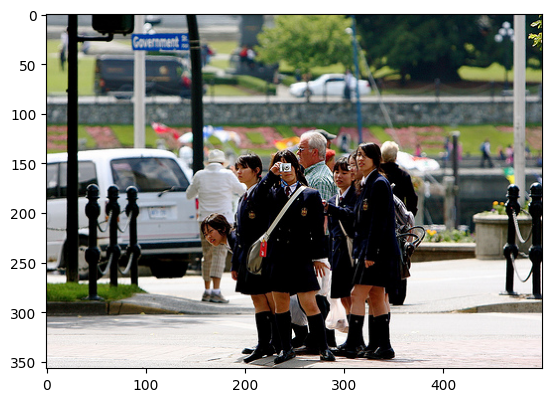

In [94]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.applications import Xception
from pickle import load

img_path = "./Flicker8k_Dataset/2532262109_87429a2cae.jpg"  # Set the image path here

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
        return None
    image = image.resize((299,299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

max_length = 32
tokenizer = load(open("tokenizer.p","rb"))

xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
if photo is not None:
    img = Image.open(img_path)
    description = generate_desc(model, tokenizer, photo, max_length)
    print(description)
    plt.imshow(img)
    plt.show()
